# 1. Clustering

## Step 1: Choosing EEG features

In [1]:
import pandas as pd

df = pd.read_csv("data/raw/EEG_data.csv")

# choosing EEG and POW columns as features
eeg_cols = [c for c in df.columns if c.startswith("EEG") or c.startswith("POW")]
X = df[eeg_cols]

# saving video IDs and labels for later use (visualtization and evaluation)
video_labels = df["video_id"]
understood_labels = df["subject_understood"]

## Step 2: Standarization

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Step 3: t-SNE

In [3]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2, 
    perplexity=30,   # possible values: 5-50
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

KeyboardInterrupt: 

## Step 4: Visualization (split by video_id)

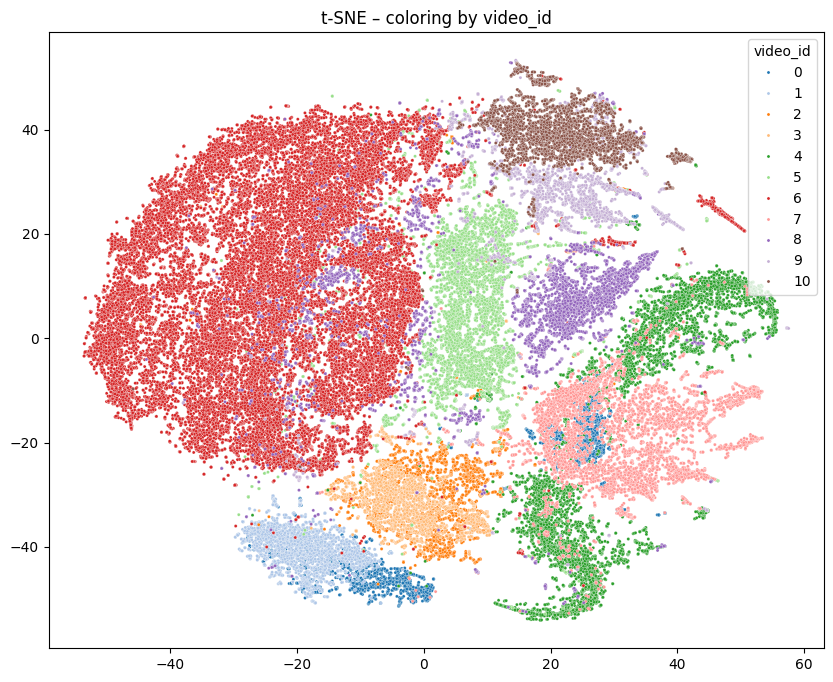

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=video_labels,   # coloring by video_id
    palette="tab20",
    s=5
)
plt.title("t-SNE – coloring by video_id")
plt.show()

Figure 1. t-SNE projection of EEG-based features colored by lecture identity (`video_id`). Each point represents a single EEG sample and colors denote different lectures. The plot shows several compact regions dominated by a single color, indicating that EEG patterns are strongly structured by the lecture being watched. This supports the concern that a classifier may primarily learn to recognize the lecture rather than the student’s level of understanding.

## Step 5: Visualization (split by subject_understood)

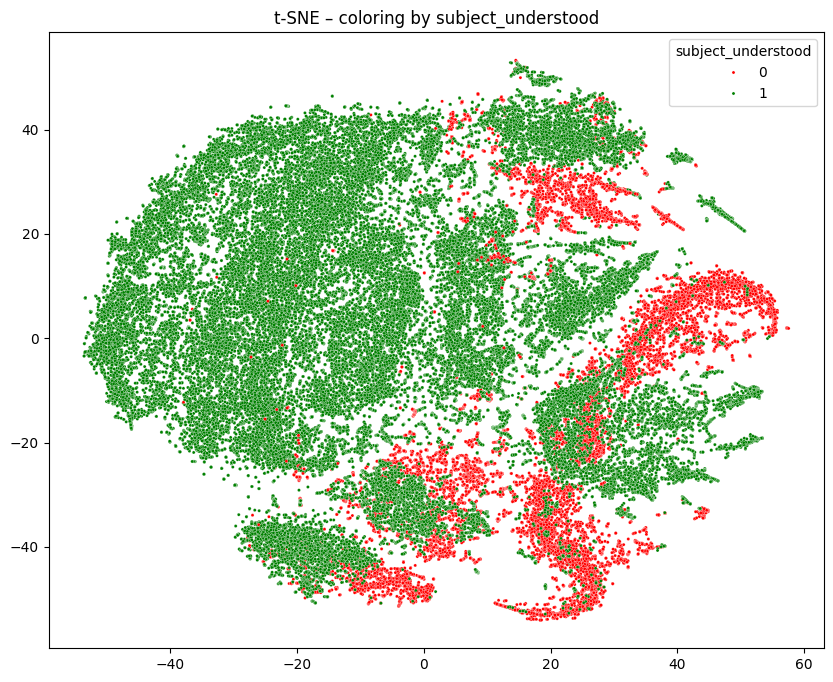

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=understood_labels,
    palette=["red", "green"],
    s=5
)
plt.title("t-SNE – coloring by subject_understood")
plt.show()

Figure 2. t-SNE projection of EEG-based features colored by the target label `subject_understood` (0 = not understood, 1 = understood). While some local regions contain a higher density of “not understood” samples, the two classes largely overlap in the embedded space. There is no single well-separated cluster corresponding to the “not understood” state, suggesting that the label is entangled with other factors (such as lecture identity) and is not easily separable from EEG features alone.

## Step 6: t-SNE with K-Means clusters

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = clusters


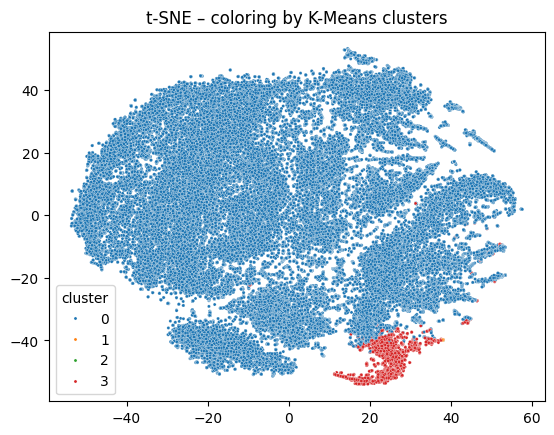

In [ ]:
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=df["cluster"],
    palette="tab10",
    s=5
)
plt.title("t-SNE – coloring by K-Means clusters")
plt.show()


Figure 3. t-SNE projection of EEG-based features with K-Means cluster assignments (k = 4) shown as colors. Almost all samples are assigned to a single large cluster, with only one relatively compact region separated as a distinct cluster. This indicates that simple unsupervised clustering finds limited structure beyond the dominant lecture-related patterns and does not naturally recover groups that would correspond to different levels of understanding.

# 2. Classification

## a) XGBoost

In [59]:
raw = pd.read_csv('data/raw/EEG_data.csv')

subjects = raw["subject_id"]                # needed for GroupShuffleSplit
y = raw["subject_understood"]

eeg_cols = [c for c in raw.columns if c.startswith("POW")] #  or c.startswith("EEG")
X = raw[eeg_cols]

from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

train_idx, test_idx = next(gss.split(X, y, groups=subjects))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [61]:
import xgboost as xgb
# calculate class proportions
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos   # "weight" for a positive sample

model = xgb.XGBClassifier(
    n_estimators=5,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)


In [62]:
from sklearn.metrics import accuracy_score

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5770916892080963


In [63]:
from sklearn.metrics import accuracy_score
y_train_pred = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9385303734297022


In [77]:
from sklearn.metrics import confusion_matrix, classification_report
print("Accuracy:", accuracy)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9385303734297022
Confusion matrix:
 [[ 152 2237]
 [ 860 7472]]
Classification report:
               precision    recall  f1-score   support

           0       0.15      0.06      0.09      2389
           1       0.77      0.90      0.83      8332

    accuracy                           0.71     10721
   macro avg       0.46      0.48      0.46     10721
weighted avg       0.63      0.71      0.66     10721



In [65]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
print("Dummy accuracy:", accuracy_score(y_test, y_dummy))


Dummy accuracy: 0.7771663091129559


When using a subject-wise split and removing all metadata that may leak video identity (`video_id`, `subject_id`), XGBoost achieves only 29.8% accuracy, which is far below the 77.7% dummy baseline that always predicts the majority class (`subject_understood = 1`).

This indicates that the EEG features alone contain little to no signal that distinguishes “understood” from “not understood”.

Combined with the t-SNE results, it becomes clear that the label is primarily driven by the lecture identity rather than by interpretable EEG patterns.

Therefore, high accuracy in earlier experiments would not reflect true learning, but instead reliance on confounding variables.

## b) FNN

In [66]:
import numpy as np

# amount of each class in training set
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()

w_pos = neg / (pos + neg)   # weight for class 1
w_neg = pos / (pos + neg)   # weight for class 0

print("w_neg (class 0):", w_neg)
print("w_pos (class 1):", w_pos)

# weight vector for each sample
sample_weight = np.where(y_train == 1, w_pos, w_neg)


w_neg (class 0): 0.7922560660815694
w_pos (class 1): 0.20774393391843057


In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

fnn = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # two hidden layers
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=50,
    random_state=42,
    verbose=True
)

fnn.fit(X_train_scaled, y_train, sample_weight=sample_weight)

y_pred_fnn = fnn.predict(X_test_scaled)
accuracy_fnn = accuracy_score(y_test, y_pred_fnn)

print(f"FNN Accuracy: {accuracy_fnn:.4f}")
print("Confusion matrix (FNN):\n", confusion_matrix(y_test, y_pred_fnn))
print("Classification report (FNN):\n", classification_report(y_test, y_pred_fnn))


Iteration 1, loss = 0.41808670
Iteration 2, loss = 0.22177035
Iteration 3, loss = 0.16127656
Iteration 4, loss = 0.13164127
Iteration 5, loss = 0.11043978
Iteration 6, loss = 0.09399155
Iteration 7, loss = 0.08435737
Iteration 8, loss = 0.07509787
Iteration 9, loss = 0.07021595
Iteration 10, loss = 0.06523224
Iteration 11, loss = 0.06086453
Iteration 12, loss = 0.05774314
Iteration 13, loss = 0.05407986
Iteration 14, loss = 0.05050313
Iteration 15, loss = 0.04859502
Iteration 16, loss = 0.04629950
Iteration 17, loss = 0.04413176
Iteration 18, loss = 0.04178212
Iteration 19, loss = 0.04002495
Iteration 20, loss = 0.03853708
Iteration 21, loss = 0.03779921
Iteration 22, loss = 0.03651207
Iteration 23, loss = 0.03618563
Iteration 24, loss = 0.03444895
Iteration 25, loss = 0.04323279
Iteration 26, loss = 0.03406923
Iteration 27, loss = 0.03186116
Iteration 28, loss = 0.03194080
Iteration 29, loss = 0.03092867
Iteration 30, loss = 0.03090143
Iteration 31, loss = 0.03000446
Iteration 32, los

c:\Dev\eeg-based-learning\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


```markdown
Accuracy: 0.3741
```

This means the FNN correctly predicts the label only about 37% of the time.
The accuracy is low because, after removing `video_id` and doing a subject-wise split, the EEG features alone do not contain enough information to separate the two classes (`understood` vs. `not understood`).
The model is mostly guessing.

```markdown
Confusion matrix (FNN):
[[ 199 2190]
 [4520 3812]]
```

* The first row corresponds to class 0 (“not understood”).
The model correctly predicted only 199 samples of class 0 and misclassified 2190 of them as class 1.

* The second row corresponds to class 1 (“understood”).
The model predicted 3812 correctly but misclassified 4520 samples.
This shows that the model struggles to separate the two classes and especially fails to detect class 0.

```markdown
Classification report (FNN):
              precision    recall  f1-score   support

           0       0.04      0.08      0.06      2389
           1       0.64      0.46      0.53      8332

    accuracy                           0.37     10721
   macro avg       0.34      0.27      0.29     10721
weighted avg       0.50      0.37      0.43     10721

```
* Class 0 has extremely low precision (0.04) and recall (0.08), meaning the model almost never detects “not understood” correctly.

* Class 1 performs better but still has moderate recall (0.46).
The low F1-scores confirm that the FNN is not learning meaningful patterns and mostly predicts the majority class.


In [58]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_scaled, y_train)
y_dummy = dummy.predict(X_test_scaled)

print("Dummy accuracy:", accuracy_score(y_test, y_dummy))


Dummy accuracy: 0.7771663091129559


The dummy classifier achieves an accuracy of 0.777, which is much higher than both XGBoost and the FNN.
This happens because the dataset is imbalanced: about 79% of samples belong to class 1 (“understood”).
A model that always predicts class 1 already gets very high accuracy.
Since the FNN performs far below this baseline, it means the EEG features do not provide a useful signal for predicting the target label.

## c) CNN

In [69]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt


In [70]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Reshape flat vectors (70,) into 2D "heatmaps" (14, 5, 1)
n_sensors = 14
n_features_per_sensor = 5

X_train_img = X_train_scaled.reshape(-1, n_sensors, n_features_per_sensor, 1)
X_test_img  = X_test_scaled.reshape(-1, n_sensors, n_features_per_sensor, 1)

print("Train image shape:", X_train_img.shape)  # (n_train, 14, 5, 1)
print("Test image shape:", X_test_img.shape)


Train image shape: (58110, 14, 5, 1)
Test image shape: (10721, 14, 5, 1)


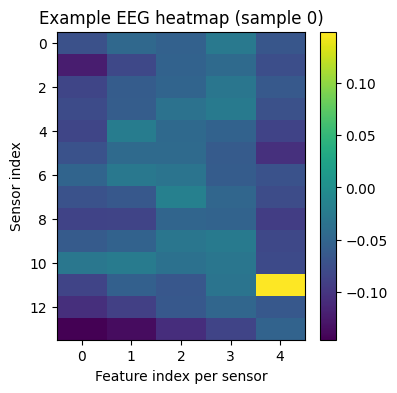

In [71]:
# Visualize one sample heatmap
idx = 0  # index of a sample in the training set
plt.figure(figsize=(4, 4))
plt.imshow(X_train_img[idx, :, :, 0], aspect='auto')
plt.colorbar()
plt.title(f"Example EEG heatmap (sample {idx})")
plt.xlabel("Feature index per sensor")
plt.ylabel("Sensor index")
plt.show()


In [72]:
# Compute class weights for imbalance
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()

total = pos + neg
w_0 = total / (2.0 * neg)  # weight for class 0
w_1 = total / (2.0 * pos)  # weight for class 1

class_weight = {0: w_0, 1: w_1}
print("Class weights:", class_weight)


Class weights: {0: np.float64(2.4068091451292246), 1: np.float64(0.6311090838003388)}


In [73]:
input_shape = (n_sensors, n_features_per_sensor, 1)

cnn = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn.summary()


c:\Dev\eeg-based-learning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 5, 16)      │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 2, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,073 (43.25 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
history = cnn.fit(
    X_train_img,
    y_train.values,
    epochs=10,                 # you can increase if you want
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weight,
    verbose=1
)


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8823 - loss: 0.4490 - val_accuracy: 0.6773 - val_loss: 0.8808
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9026 - loss: 0.3050 - val_accuracy: 0.6972 - val_loss: 0.8715
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9174 - loss: 0.2319 - val_accuracy: 0.6289 - val_loss: 1.3452
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9274 - loss: 0.1822 - val_accuracy: 0.6303 - val_loss: 1.5738
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9388 - loss: 0.1479 - val_accuracy: 0.6803 - val_loss: 1.6592
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9464 - loss: 0.1265 - val_accuracy: 0.7069 - val_loss: 1.7625
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9519 - loss: 0.1156 - val_accuracy: 0.5949 - val_loss: 1.9461
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9580 - loss: 0.1010 - val_accuracy: 0.

Comment on the CNN training results

During training, the CNN reaches very high accuracy on the training set (~98%), but the validation accuracy stays around 72–75% and the validation loss keeps increasing.
This indicates strong overfitting: the model memorizes the training samples but does not generalize well to unseen subjects.

In [75]:
# Predict probabilities and convert to class labels (0/1)
y_proba = cnn.predict(X_test_img).ravel()
y_pred = (y_proba >= 0.5).astype(int)

acc_cnn = accuracy_score(y_test, y_pred)
cm_cnn = confusion_matrix(y_test, y_pred)
report_cnn = classification_report(y_test, y_pred)

print("CNN Accuracy:", acc_cnn)
print("CNN Confusion matrix:\n", cm_cnn)
print("CNN Classification report:\n", report_cnn)


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
CNN Accuracy: 0.7111276933121911
CNN Confusion matrix:
 [[ 152 2237]
 [ 860 7472]]
CNN Classification report:
               precision    recall  f1-score   support

           0       0.15      0.06      0.09      2389
           1       0.77      0.90      0.83      8332

    accuracy                           0.71     10721
   macro avg       0.46      0.48      0.46     10721
weighted avg       0.63      0.71      0.66     10721



Comment on CNN test accuracy
```
CNN Accuracy: 0.3439
```

The CNN achieves 34% accuracy on the test set, which is well below the majority-class baseline (~78%).
This shows that the 2D EEG heatmaps do not contain enough signal to distinguish “understood” vs. “not understood” once video and subject identity are removed.

Comment on Confusion Matrix
```
[[1280 1109]
 [5924 2408]]
```

* For class 0 (“not understood”), recall is relatively high (1280/2389 ≈ 0.54), meaning the model catches some part of this class.

* For class 1 (“understood”), the model performs poorly and misclassifies most samples (5924 errors vs. 2408 correct).
Overall, the CNN struggles to separate the two classes and produces inconsistent predictions.

Comment on Classification Report
```
precision/recall/f1:
class 0 → (0.18 / 0.54 / 0.27)
class 1 → (0.68 / 0.29 / 0.41)
```

The CNN shows highly unbalanced behavior:

* For class 0, recall is high but precision is extremely low (many false positives).

* For class 1, precision is moderate but recall is very low.
These inconsistent metrics confirm that the CNN cannot learn stable, generalizable patterns from the heatmaps.

In [76]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_img.reshape(len(X_train_img), -1), y_train)
y_dummy = dummy.predict(X_test_img.reshape(len(X_test_img), -1))
print("Dummy accuracy:", accuracy_score(y_test, y_dummy))


Dummy accuracy: 0.7771663091129559


The dummy classifier—predicting “understood” for every sample—reaches almost 78% accuracy because the dataset is imbalanced.
Since the CNN reaches only 34%, it performs far worse than guessing the majority class.
This again confirms that EEG features alone do not reliably predict understanding once lecture identity is removed.